# Лабораторная работа №9
## Выполнили Зимин Андрей Валерьевич и Жилин Андрей Игоревич

## Импорт библиотек

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.decomposition import PCA
import seaborn as sns

## Задание 1

Датасет взят из 2-го сезона соревнований "CodeRun" от компании Яндекс.
  
Название задачи: Внимание, выброс!  
Текст задачи: Когда Меченый возглавил Институт изучения Зоны, его заинтересовали некоторые аномалии −− а именно выбросы, у которых определенные характеристики заметно отличались от остальных. Все его размышления были зафиксированы в КПК. К несчастью, КПК разгрызла псевдособака во время очередной вылазки, однако сами данные у Меченого остались в его лаборатории. Помогите ему заново отыскать аномальные выбросы среди имеющихся.

## Загрузка датасета

In [2]:
data = []
with open('./data/attention_to_emission_input.txt') as file:
    n, m = map(int, file.readline().split())
    print(f"Количество объектов:  {n}")
    print(f"Количество признаков: {m}")
    data = [[float(i) for i in file.readline().split()] for i in range(n)]
    data = np.array(data)

print("Первые 5 объектов датасета:")
data[:5, :]

Количество объектов:  50000
Количество признаков: 21
Первые 5 объектов датасета:


array([[  5364.99051,  38422.22028, -10923.25435,  35446.1303 ,
          -858.984  ,  10325.9377 ,  31904.70633,   3896.82932,
        -12560.83585,  29599.56183,  28665.86994, -44815.3644 ,
         48559.2683 ,  37184.85332, -30313.60702,   9709.31394,
          9718.03056, -12493.37933,   3392.91717,  23958.0602 ,
         19563.31532],
       [ 13531.96893,  -5139.29811,  32354.33063, -27853.16773,
        -44825.165  , -16643.67839,  -2880.86854,  42545.55648,
        -51394.84482, -30060.57781,  -9170.93692,  44487.83686,
        -37139.58191,  19280.63521,  40905.35507,  -9265.8577 ,
        -35556.67857, -22513.34943, -25921.42495, -19574.1461 ,
        -23971.2915 ],
       [-40730.57093, -34712.44863, -22597.97151, -43063.01155,
        -30992.24051, -36254.15373,   9707.03461, -10288.19612,
          1054.2411 , -32319.18406,  18003.3523 , -42117.80536,
         -9832.11708,  -8430.87892,   6071.1254 ,  43223.38662,
         15212.80469, -39302.27905,  40341.3013 , -48793.8

Как мы видим:  
- датасет достаточно большой, с ним будет интересно работать    
- данные без пропусков, все признаки непрерывные, из одного диапазона

Вывод: скорее всего датасет синтетический

Посмотрим на диаграмму рассеяния. Здесь нам нужно взять только два признака для отрисовки, поэтому применяем метод главных компонент и смотрим на распределение

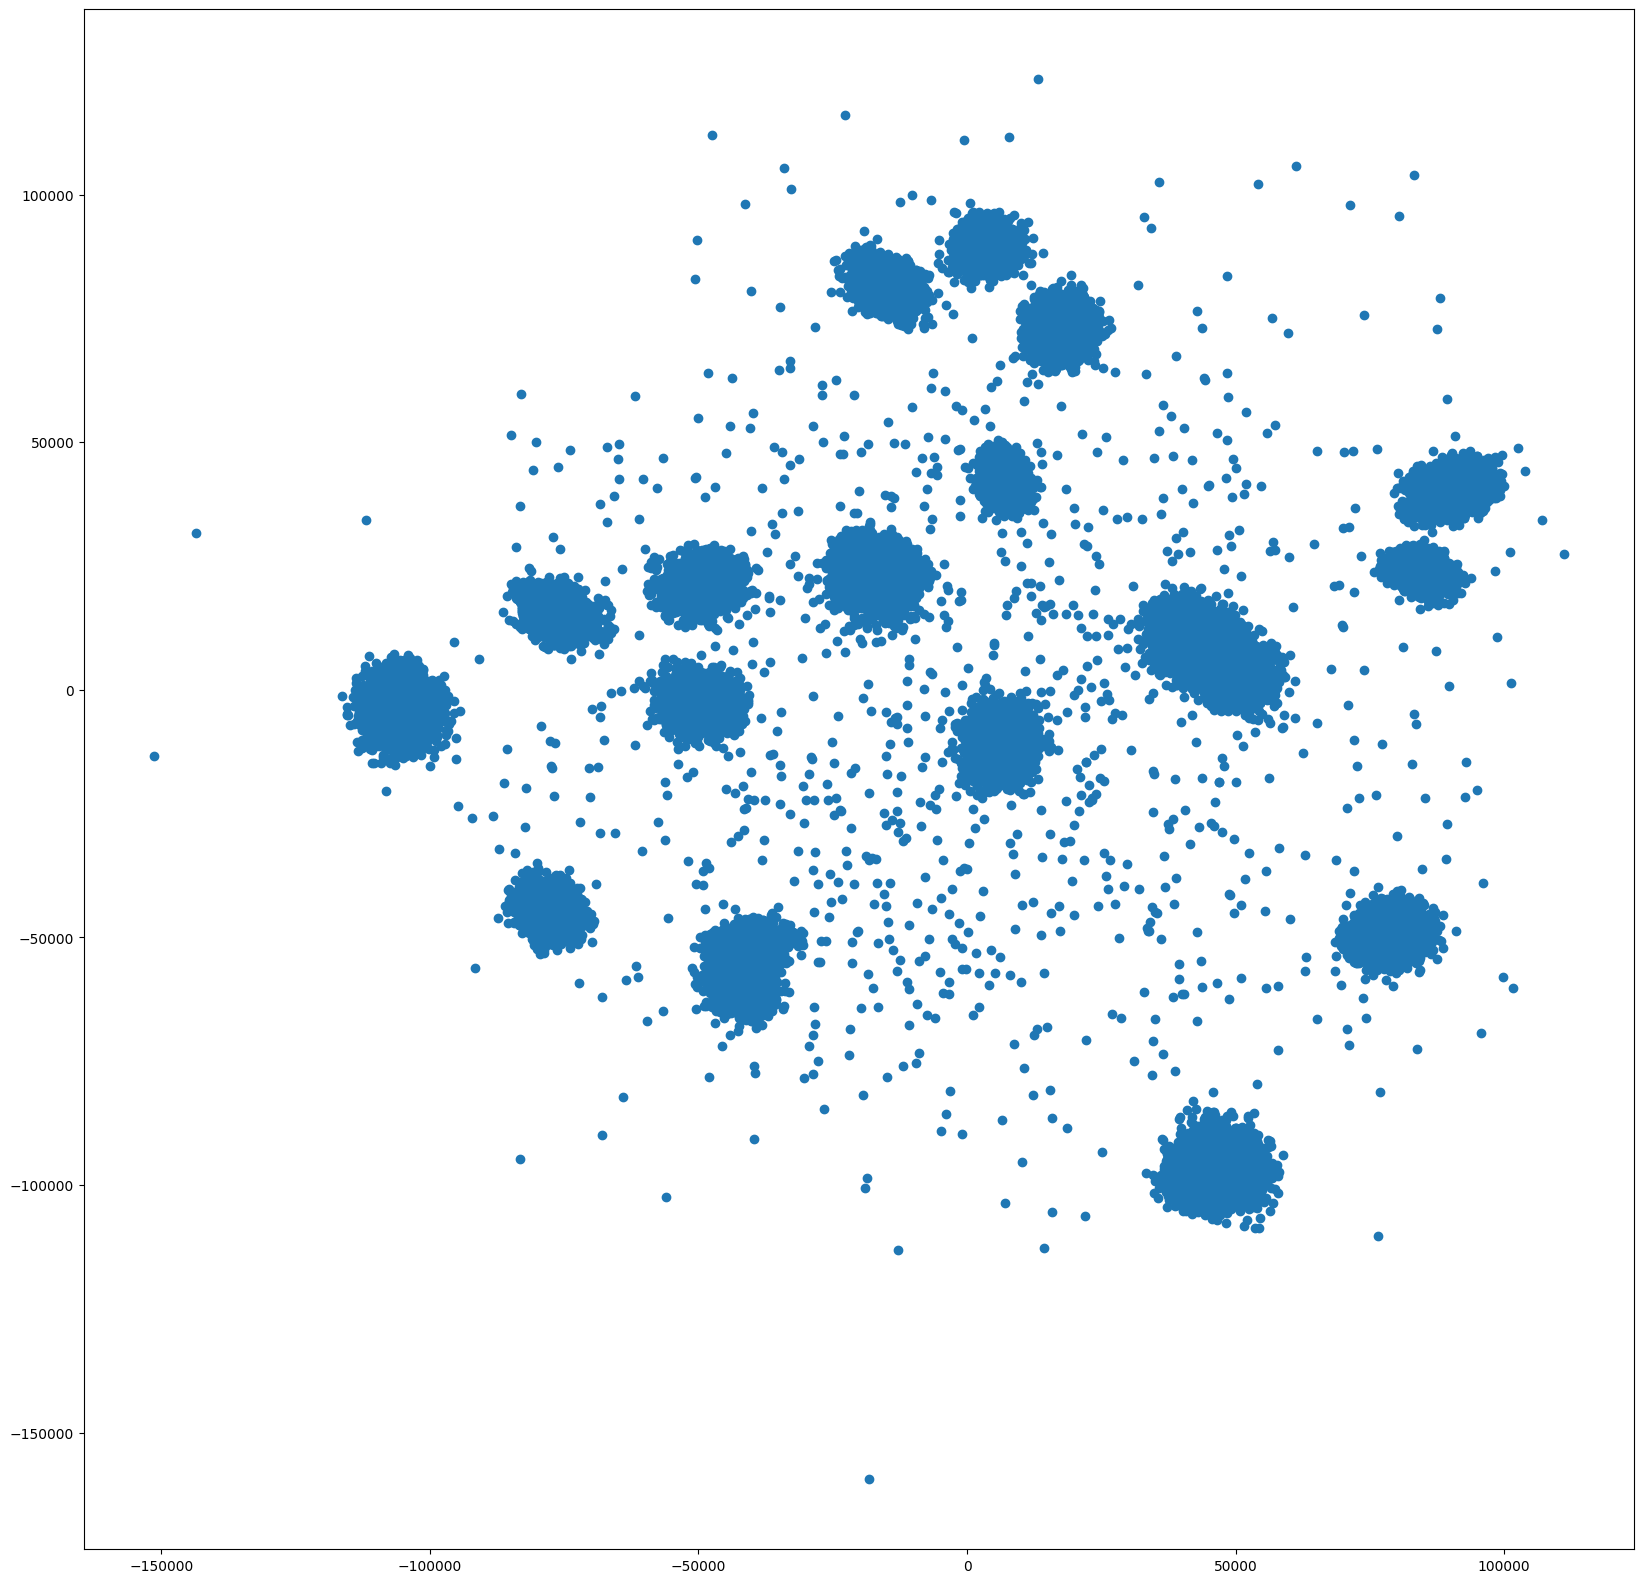

In [3]:
pca = PCA(n_components=2)
d2 = pca.fit_transform(data)
d2.shape
plt.figure(figsize=(20,20))
plt.scatter(d2[:, 0], d2[:, 1])

Вывод: видны 17 плотных скоплений объектов, которые можно назвать кластерами. Оставшиеся объекты будем считать выбросами

In [13]:
class DBScan:
    def __init__(self, esp, min_pts, metric):
        self.esp = esp
        self.min_pts = min_pts
        self.metric = metric

    def fit_predict(self, X):
        # построим матрицу расстояний distance от каждого объекта до каждого
        n = X.shape[0]
        self.distance = np.zeros((n, n))
        for i in range(n-1):
            for j in range(i+1, n):
                value = self.metric(X[i, :], X[j, :])
                self.distance[i][j] = value
                self.distance[j][i] = value

        # определение корневых точек
        root = [sum(self.distance[i, :] < self.esp) >= self.min_pts for i in range(n)]
        # определение граничных точек
        border = [(not root[i]) and (True in [root[j] and (self.distance[i, j] < self.esp) for j in range(n)]) for i in range(n)]
        # определение выбросов
        noise = [not (root[i] or border[i]) for i in range(n)]
        #return root, border, noise

        # Создаем метки классов
        labels = -1 * np.ones(n, dtype=int)  # Изначально все метки -1 (шум)
        cluster_id = 0

        # Присваиваем метки классам
        for i in range(n):
            if root[i] and labels[i] == -1:  # Если это корневая точка и она еще не имеет метки
                labels[i] = cluster_id  # Присваиваем метку кластеру
                self._expand_cluster(i, labels, cluster_id)  # Расширяем кластер
                cluster_id += 1  # Увеличиваем идентификатор кластера для следующего кластера

        return labels

    def _expand_cluster(self, point_idx, labels, cluster_id):
        # Получаем индексы соседей для текущей точки
        neighbors = [j for j in range(len(labels)) if self.distance[point_idx, j] < self.esp]

        # Присваиваем метки всем соседям
        for neighbor_idx in neighbors:
            if labels[neighbor_idx] == -1:  # Если сосед еще не помечен
                labels[neighbor_idx] = cluster_id  # Присваиваем метку текущему кластеру
                self._expand_cluster(neighbor_idx, labels, cluster_id)  # Рекурсивно расширяем кластер

C:\Users\sai\AppData\Local\Temp\ipykernel_2796\226505475.py:15: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


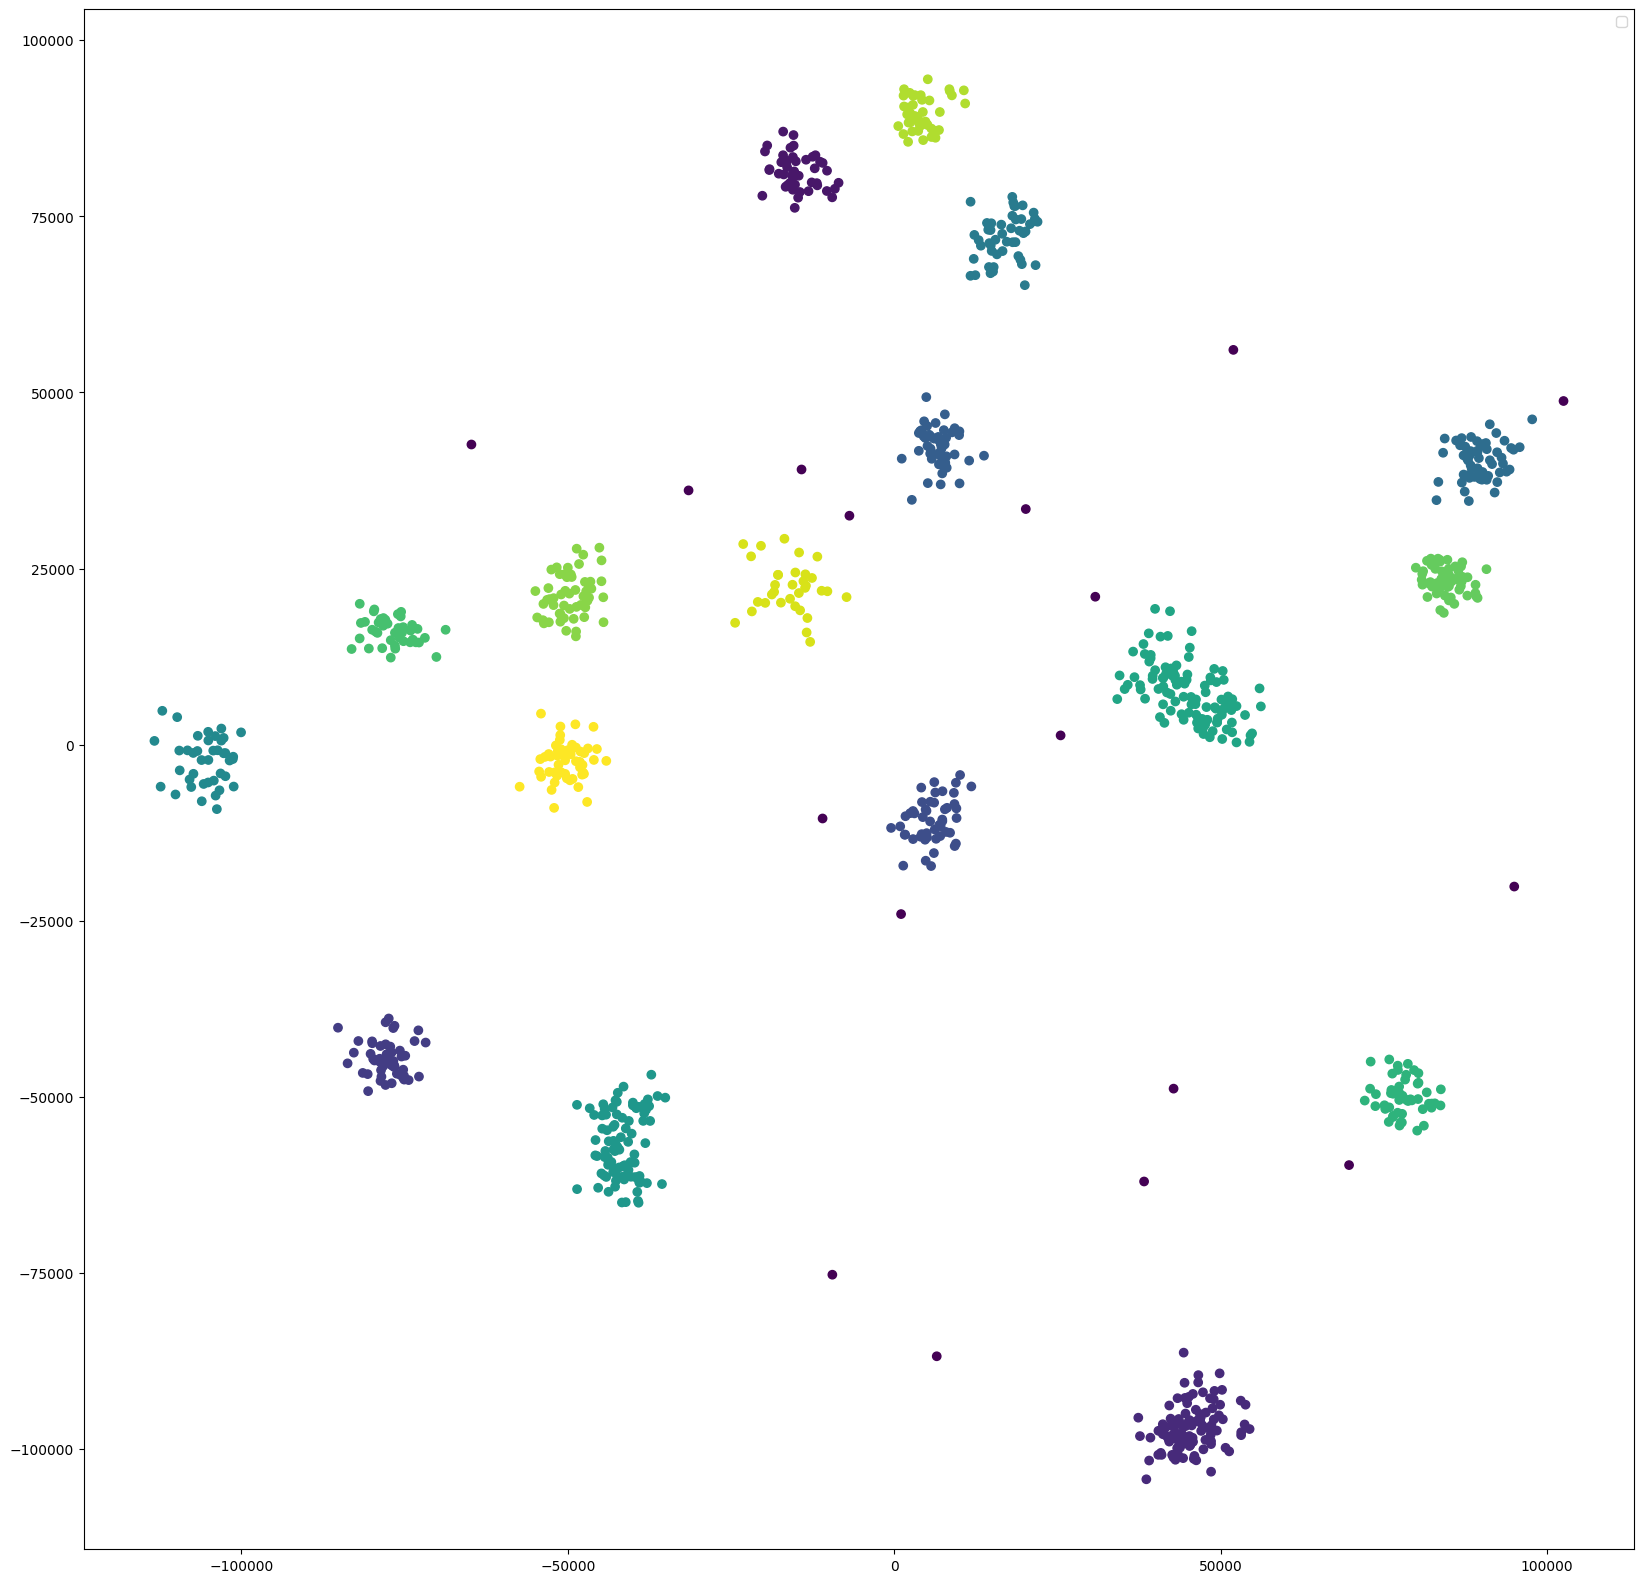

In [14]:
# model = DBScan(esp=5000, min_pts=5, metric=lambda x1, x2: sum((x1-x2)**2)**0.5)
# root, border, noise = model.fit_predict(d2[:1000])
# plt.figure(figsize=(20,20))
# plt.scatter(d2[:1000, 0][noise], d2[:1000, 1][noise], color="blue", label="Шумовые точки")
# plt.scatter(d2[:1000, 0][root], d2[:1000, 1][root], color="red", label="Корневые точки кластеров")
# plt.scatter(d2[:1000, 0][border], d2[:1000, 1][border], color="orange", label="Граничные точки")
# plt.legend()

model = DBScan(esp=5000, min_pts=5, metric=lambda x1, x2: sum((x1-x2)**2)**0.5)
labels = model.fit_predict(d2[:1000])

#names = ["Выброс" if i == -1 else f"Кластер {i}" for i in labels]
plt.figure(figsize=(20,20))
plt.scatter(d2[:1000, 0], d2[:1000, 1], c=labels)
plt.legend()